# Binary Classification and Propensity Notebook 

Equipped with the historical data, we should set out on the task to identify the customers with the highest propensity (an inclination) to buy a specific product. When dealing with this kind of problems, we should look at some questions of business factors influencing a propensity to buy the specific product:  

- Would age be a factor?
- Is there any relationship between employment status and the propensity to buy the product (e.g. term deposits)?
- Would the asset portfolio of a customer influence the propensity to buy?
- Will demographics such as marital status and education influence the propensity to buy term deposits? 

In [1]:
# Global variables
delta=0.00001 # used to "correct" zero values coming from the MinMaxScaler normalisation procedure

### Dataset from S. Moro, P. Cortez, and P. Rita: A Data-Driven approach to predict the success of bank telemarketing

In [2]:
import pandas as pd

In [3]:
file_url='https://raw.githubusercontent.com/PacktWorkshops'\
         '/The-Data-Science-Workshop/master/Chapter03'\
         '/bank-full.csv'

# Loading the data using Pandas
bankData=pd.read_csv(file_url, sep=';')
bankData_2=pd.read_csv(file_url, sep=';')
# Dropna removes NaN values from the DataSet
bankData_cleaned=bankData.dropna()

# Printing the shape of the DataSet
print('The shape of the DataSet is:', bankData.shape)

The shape of the DataSet is: (45211, 17)


In [4]:
# Summarising the statistics of the numerical raw Data (only for Numerical Data)
bankData.describe()[1:3]

,age,balance,day,duration,campaign,pdays,previous
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441


## Exploratory Data Analysis (EDA): evolving some hypotheses about the relationship of these business drivers and the business outcome

In [5]:
# Importing library files
import numpy as np 
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
# HYPOTHESIS: The propensity to buy deposits is more with elderly customers compared to younger ones.

filter_mask=bankData['y']=='yes' # 'y' means -> the customer bought a term deposit

# Here, we use a GroupBy on the bankData DataSet: .agg is the aggregative function used to realise a SQL Distribution. 'Agegrp' is the number of the aggregated column. 
bankSub1=bankData[filter_mask].groupby('age')['y'].agg(agegrp='count').reset_index()
bankSub1.head()

,age,agegrp
0,18,7
1,19,11
2,20,15
3,21,22
4,22,40


In [7]:
# Visualising the relationship between 'age' and how many of them actually bought a term deposit. This is the absolute counting of customers!
alt.Chart(bankSub1).mark_line().encode(x='age', y='agegrp')

alt.Chart(...)

In [8]:
# The previous output seems to be counterintuitive: what we should plot is the proportion of customers, within each age group, who buy a term deposit (in the previous output, we plotted
# the absolute counting of customers). 

# Before applying the filtering mask, we perform a .groupby on the DataSet age to define the 'ageProp' DataSet
ageProp=bankData.groupby(['age','y'])['y'].agg(ageTotYN='count').reset_index()
# DataSet containing the customers grouped by age
agePropY=bankData.groupby('age')['y'].agg(ageTot='count').reset_index()

In [9]:
# LEFT JOIN of the two DataSets: ageProp and agePropY are joined on the 'age' feature.
ageComb=pd.merge(ageProp,agePropY,left_on=['age'],right_on=['age'])

# Here we build the catProp feature representing a way to visually represent the percentage of customers buying/not buying the deposit term
ageComb['catProp']=round((ageComb.ageTotYN/ageComb.ageTot)*100,2)

In [10]:
# Visualising the relationships with Altair --- OJO: when we see a 'saturation' in the Plot, we cannot do correct considerations
alt.Chart(ageComb).mark_line().encode(x='age', y='catProp').facet(column='y')

alt.FacetChart(...)

In [11]:
# We try to formulate a hypothesis between employment status and the propensity to buy term deposits. 
# HYPOTHESIS: High paying employees prefer term deposits than other categories of employees

# Performing a groupby only on the Job column
jobTot=bankData.groupby('job')['y'].agg(jobgrpTot='count').reset_index()
# Performing a groupby on the Job and the Y column
jobProp=bankData.groupby(['job','y'])['y'].agg(jobgrp='count').reset_index()

# LEFT JOIN on the job column (from both the SubDataSets)
jobComb=pd.merge(jobProp,jobTot,left_on='job',right_on='job')

# Add a Percentage column
jobComb['jobPerc']=round((jobComb.jobgrp/jobComb.jobgrpTot)*100,2)
jobComb.head()

,job,y,jobgrp,jobgrpTot,jobPerc
0,admin.,no,4540,5171,87.80
1,admin.,yes,631,5171,12.20
2,blue-collar,no,9024,9732,92.73
3,blue-collar,yes,708,9732,7.27
4,entrepreneur,no,1364,1487,91.73


In [12]:
# Visualising the relationships with Altair --- OJO: when we see a 'saturation' in the Plot, we cannot do correct considerations
alt.Chart(jobComb).mark_bar().encode(x='job', y='jobPerc').facet(column='y')

alt.FacetChart(...)

## Feature Engineering

Feature Engineering is the process of transforming raw variables to create new variables and it is one of the most important steps that influence the accuracy of the models that we build. There are two types of Feature Engineering (FE):   

- Transform raw variables based on intuitions from a business perspective (Type I);
- The transformation of raw variables is done from a statistical and data normalisation perspective (Type II). 

### Type I FE

Transforming data and creating new variables on business factors or drivers that influence a business problem: in this context, we will explore an 'asset portfolio' representing the combination of all assets and liabilities the customer has with the bank. We will combine assets and liabilities such as bank balance, home ownership, and loans to get a new feature called ASSET index. 

HOW TO?

- We give a weight of 5 if the customer has a house and 1 in its absence;
- We give a weight of 1 if the customer has a loan and 5 in case of no loans. 

In [13]:
# Normalising data
from sklearn import preprocessing 

In [14]:
# Getting a Numpy array converting balance into float numbers
x=bankData[['balance']].values.astype(float)

In [15]:
# In order to normalise data, we use MinMaxScaler() from Sklearn -> the purpose of normalisation is to bring all of the variables that we are using to 
# create the new feature into a common scale. 

minmaxscaler=preprocessing.MinMaxScaler()
bankData['balance_norm']=minmaxscaler.fit_transform(x)
bankData.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balance_norm
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0.092259
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0.073067
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0.072822
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0.086476
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0.072812


In [16]:
# NB. When using MinMaxScaler, df['name_of_the_new_column'].min() is zero. We sum a small \Delta \sim 10^-4 to the whole column. 

bankData['balance_norm']=bankData['balance_norm']+delta 

In [17]:
# LOAN ENGINEERING

# Adding a new column containing WEIGHTS for LOAN
bankData['loanTran']=1
# Giving a weight of 5 if there is no loan 
bankData.loc[bankData['loan']=='no','loanTran']=5

In [18]:
# HOUSING DATA ENGINEERING

# Adding a new column containing WEIGHTS for HOUSING
bankData['houseTran']=5
# Giving a weight of 1 if the customer has not a House
bankData.loc[bankData['housing']=='no','houseTran']=1

In [19]:
# We can now create a new variable called AssetIndex which can be defined as the product of 'loanTran', 'houseTran', and 'balance_norm'. This is a composite
# index representing the combined effect of all the three variables
bankData['assetIndex']=bankData['balance_norm']*bankData['loanTran']*bankData['houseTran']
bankData.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,balance_norm,loanTran,houseTran,assetIndex
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,261,1,-1,0,unknown,no,0.092269,5,5,2.306734
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,151,1,-1,0,unknown,no,0.073077,5,5,1.826916
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,76,1,-1,0,unknown,no,0.072832,1,5,0.364158
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,92,1,-1,0,unknown,no,0.086486,5,5,2.162153
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,198,1,-1,0,unknown,no,0.072822,5,1,0.364112


In [20]:
# In what follows, we observe the relationship between the asset index and the propensity of term deposit purchases. For the purpose, we take the quantiles 
# and then we map the quantiles to the propensity of term deposit purchases. 

# Finding the quantiles
np.quantile(bankData['assetIndex'],[0.25,0.5,0.75])

array([0.37668646, 0.56920367, 1.9027249 ])

In [21]:
# We establish the asset Class by looking at the value of the assetIndex

# Firstly, we polarise the column with 'Quant1'
bankData['assetClass']='Quant1'
# Then we set the remaining quantiles
bankData.loc[(bankData['assetIndex']>0.38) & (bankData['assetIndex']<0.57),'assetClass']='Quant2'
bankData.loc[(bankData['assetIndex']>0.57) & (bankData['assetIndex']<1.90),'assetClass']='Quant3'
bankData.loc[bankData['assetIndex']>1.90,'assetClass']='Quant4'

In [22]:
bankData.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,balance_norm,loanTran,houseTran,assetIndex,assetClass
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,1,-1,0,unknown,no,0.092269,5,5,2.306734,Quant4
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,-1,0,unknown,no,0.073077,5,5,1.826916,Quant3
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,-1,0,unknown,no,0.072832,1,5,0.364158,Quant1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,1,-1,0,unknown,no,0.086486,5,5,2.162153,Quant4
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,-1,0,unknown,no,0.072822,5,1,0.364112,Quant1


In [23]:
# We compute the percentages of term deposits for each assetClass
assetAggrTot=bankData.groupby(['assetClass'])['y'].agg(aggClassTot='count').reset_index()
assetAggrYN=bankData.groupby(['assetClass','y'])['y'].agg(aggClassYN='count').reset_index()
assetComb=pd.merge(assetAggrYN,assetAggrTot,left_on='assetClass',right_on='assetClass')

In [24]:
assetComb['assetPerc']=round((assetComb.aggClassYN/assetComb.aggClassTot)*100,2)
assetComb.head(10)

,assetClass,y,aggClassYN,aggClassTot,assetPerc
0,Quant1,no,10921,12212,89.43
1,Quant1,yes,1291,12212,10.57
2,Quant2,no,8436,10400,81.12
3,Quant2,yes,1964,10400,18.88
4,Quant3,no,10144,11121,91.21
5,Quant3,yes,977,11121,8.79
6,Quant4,no,10421,11478,90.79
7,Quant4,yes,1057,11478,9.21


In [25]:
# Visualising the relationships with Altair --- OJO: when we see a 'saturation' in the Plot, we cannot do correct considerations
alt.Chart(assetComb).mark_bar().encode(x='assetClass', y='assetPerc').facet(column='y')

# From the plot, we can conclude that the customers in the Second Quartile have the highest propensity to buy term deposits!!!

alt.FacetChart(...)

### Type II FE

The first approach when doing Type II FE is to look at the correlation matrix and its visualisation. Correlation is a measure that indicates how to variables fluctuate together. Any correlation value of 1, or near 1, indicates that those variables are highly correlated. Highly correlated variables can sometimes be damaging for the veracity of models and, in many circumstances, we make the decision to eliminate such variables or to combine them to form composite or interactive models. 

In [26]:
from pandas import set_option

bankNumeric=bankData[['age','balance','day','duration','campaign','pdays','previous']]

In [27]:
# Correlation DataSet created using the Pearson correlation coefficient 
set_option('precision',3)
bankCorr=bankNumeric.corr(method='pearson')
bankCorr

,age,balance,day,duration,campaign,pdays,previous
age,1.000,0.098,-0.009,-0.005,0.005,-0.024,0.001
balance,0.098,1.000,0.005,0.022,-0.015,0.003,0.017
day,-0.009,0.005,1.000,-0.030,0.162,-0.093,-0.052
duration,-0.005,0.022,-0.030,1.000,-0.085,-0.002,0.001
campaign,0.005,-0.015,0.162,-0.085,1.000,-0.089,-0.033
pdays,-0.024,0.003,-0.093,-0.002,-0.089,1.000,0.455
previous,0.001,0.017,-0.052,0.001,-0.033,0.455,1.000


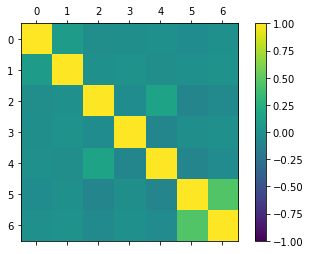

In [28]:
# In what follows, we plot the Correlation DataSet
corFig=plt.figure()
figAxis=corFig.add_subplot(111)
corAx=figAxis.matshow(bankCorr,vmin=-1,vmax=1)
corFig.colorbar(corAx)
plt.show()

# From the plot, we can conclude that there aren't many variables that are highly correlated!

#### SKEWNESS OF DATA

Skewed data means data that is shifted in one direction or the other. Skewness can cause ML models to underperform. Many ML models assume normally distributed data or data structures to follow the Gaussin structure. Any deviation from the assumed Gaussian structure can affect model performance. 

Type II FE tries to correct the skewness through normalisation of the data.

In [29]:
# The .skew() method returns the skewness index for the features. Any value close to 0 indicates a low degree of skewness. Positive values indicates right skew
# and negative values a left skew. Variables showing high values of right skew and left skew are candidates for Type II FE.

bankNumeric.skew()

age          0.685
balance      8.360
day          0.093
duration     3.144
campaign     4.899
pdays        2.616
previous    41.846
dtype: float64

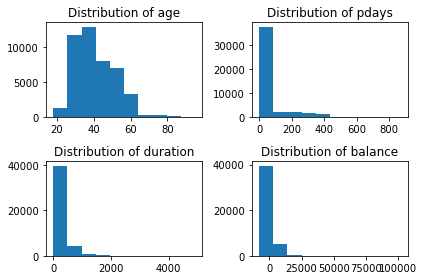

In [30]:
# Histograms
fig,axs=plt.subplots(2,2)

axs[0,0].hist(bankNumeric['age'])
axs[0,0].set_title('Distribution of age')

axs[0,1].hist(bankNumeric['pdays'])
axs[0,1].set_title('Distribution of pdays')

axs[1,0].hist(bankNumeric['duration'])
axs[1,0].set_title('Distribution of duration')

axs[1,1].hist(bankNumeric['balance'])
axs[1,1].set_title('Distribution of balance')

# Ensure plots do not overlap
plt.tight_layout()

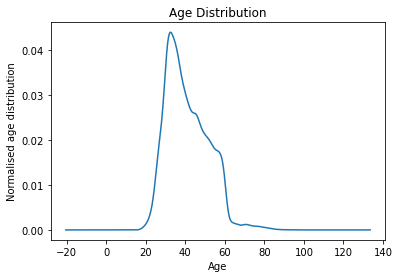

In [31]:
# Density plots: DPs help in visualising the distribution of data. A density plot can be created using the - kind='density'- parameter as follows
bankNumeric['age'].plot(kind='density',subplots=False,layout=(1,1))
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Normalised age distribution')
plt.show()

# From the density plot of 'age', we can see that it has a distribution similar to a bell curve.

### Alternative FE Methods

In what follows, we discuss standard scaler and normaliser methods. 

Standard scaler standardizes data to a mean of zero and standard deviation of 1. The mean is the average of the data and the standard deviation is a measure of the spread of data. Standard scaler is applied columnwise. In other words, STANDARD SCALER COMPUTES THE Z-SCORES OF THE COLUMNS IN THE DATASET: (x-\mu)/(\sigma). STANDARDIZING IS MORE USEFUL IN ALGORITHMS THAT ASSUME INPUT VARIABLES TO HAVE A GAUSSIAN STRUCTURE (regressions).

The normaliser function normalises the length of data: each value in a row is divided by the normalization of the row vector to normalize the row. NORMALIZATION TECHNIQUES ARE MORE CONGENIAL FOR SPARSE DATASETS (DATASETS WITH A LOT OF ZEROS) WHEN USING ALGORITHMS SUCH AS K-NEAREST NEIGHBOR OR NEURAL NETWORKS.

In [32]:
# Standard scaler - standardizes data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler
from numpy import set_printoptions

scaling=StandardScaler().fit(bankNumeric)
rescaledNum=scaling.transform(bankNumeric)

set_printoptions(precision=3)
print(rescaledNum)

[[ 1.607  0.256 -1.298 ... -0.569 -0.411 -0.252]
 [ 0.289 -0.438 -1.298 ... -0.569 -0.411 -0.252]
 [-0.747 -0.447 -1.298 ... -0.569 -0.411 -0.252]
 ...
 [ 2.925  1.43   0.143 ...  0.722  1.436  1.05 ]
 [ 1.513 -0.228  0.143 ...  0.399 -0.411 -0.252]
 [-0.371  0.528  0.143 ... -0.247  1.476  4.524]]


In [33]:
# Normalising data (each row has length 1, i.e. if we compute the norm of a random row we get 1)
from sklearn.preprocessing import Normalizer
normalizer=Normalizer().fit(bankNumeric+0.001)
normalisedNum=normalizer.transform(bankNumeric+0.001)

set_printoptions(precision=3)
print(normalisedNum)

[[ 2.686e-02  9.923e-01  2.316e-03 ...  4.635e-04 -4.626e-04  4.630e-07]
 [ 2.750e-01  1.812e-01  3.125e-02 ...  6.256e-03 -6.243e-03  6.249e-06]
 [ 3.974e-01  2.410e-02  6.022e-02 ...  1.205e-02 -1.203e-02  1.204e-05]
 ...
 [ 1.235e-02  9.805e-01  2.917e-03 ...  8.580e-04  3.157e-02  5.149e-04]
 [ 6.775e-02  7.940e-01  2.021e-02 ...  4.756e-03 -1.187e-03  1.189e-06]
 [ 1.234e-02  9.906e-01  5.669e-03 ...  6.672e-04  6.269e-02  3.668e-03]]


## Logistic Regression Model for propensity prediction

In what follows, we will build a Logistic Regression Model for propensity prediction. This part will be divided in three steps:    
- First step: preprocessing of the data
- Second step: training process
- Third step: prediction, analysis of metrics, and strategies for the improvement of the model. 

In [34]:
# In doing preprocessing of the data, we will convert the ordinal data into dummy data and we then split the data in training and testing sets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Convert ordinal data into dummy data: for such a purpose we use pd.get_dummies() -> it is like a one-hot encoding
# In bankData_2: 9 ORDINAL VARIABLES, 7 NUMERICAL VARIABLES, 1 TARGET VARIABLE

bankCat=pd.get_dummies(bankData_2[['job','marital','education','default','housing','loan','contact','month','poutcome']])
bankCat.shape

(45211, 44)

In [35]:
# We define bankNum containing the numerical variables of the DataSet
bankNum=bankData_2[['age','balance','day','duration','campaign','pdays','previous']]
bankNum.shape

(45211, 7)

In [37]:
# Preparing the X variables
X=pd.concat([bankCat,bankNum],axis=1)
print(X.shape)

(45211, 51)


In [38]:
# Preparing the Y variable
Y=bankData['y']
print(Y.shape)

(45211,)


In [39]:
X.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,58,2143,5,261,1,-1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,44,29,5,151,1,-1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,33,2,5,76,1,-1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,47,1506,5,92,1,-1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,33,1,5,198,1,-1,0


In [40]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=123)

# Now the data is all prepared for the modelling task. For now on, we begin with modelling.
bankModel=LogisticRegression()

In [41]:
bankModel.fit(X_train,y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [42]:
pred=bankModel.predict(X_test)
print('Accuracy of Logistic regression model'\
     'prediction on test set: {:2f}'\
     .format(bankModel.score(X_test,y_test)))

Accuracy of Logistic regression modelprediction on test set: 0.890445


In [43]:
# Confusion matrix for the model
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(y_test, pred)
print(confusionMatrix)

[[11754   244]
 [ 1242   324]]
